# Head
### Import libraries

In [1]:
import h5py
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM,DTYPE_EP
import pandas as pd
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
import os.path

### Truncate a smaller file for testing, or alternatively using `stop`

In [2]:
# f = pd.read_hdf('../h5files/events_anomalydetection.h5', stop=1000) #read only first 'stop' events
# # f.to_hdf('../h5files/events_anomalydetection_1000.h5', key='df')
# events_combined = f.T
# np.shape(events_combined)

### Read h5 file and transpose the matrix

In [3]:
f = pd.read_hdf('../h5files/events_anomalydetection.h5')
events_combined = f.T
print(np.shape(events_combined.columns))
H5output = '../h5files/'

(2101, 1100000)


# Reconstruct jets using fastjet and plot jet area

In [15]:
def reconstruction(kt = -1, r = 0.4, R = 1.0, pcut = 20, fillGhost = True, plotArea = True):
    
    #Now, let's cluster some jets more efficiently!
    all_largeRjets = {}
    all_smallRjets = {}
    all_hadrons = {}

    all_largeRjets_ghost = {}
    all_smallRjets_ghost = {}
    all_hadrons_ghost = {}

    # define eta and phi ranges and number of bins along each axis
    eta_min, eta_max = -5., 5.
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 200
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    for mytype in ['background','signal']:
        all_largeRjets[mytype]=[]
        all_smallRjets[mytype]=[]
        all_hadrons[mytype]=[]
        all_largeRjets_ghost[mytype]=[]
        all_smallRjets_ghost[mytype]=[]
        all_hadrons_ghost[mytype]=[]

        for ievt in range(len(events_combined.columns)):
            if ievt%10000==0:
                print(mytype,ievt)
            issignal = events_combined[ievt][2100]
            if (mytype=='background' and issignal):
                continue
            elif (mytype=='signal' and issignal==0):
                continue
            pseudojets_input = np.zeros(len([x for x in events_combined[ievt][::3] if x > 0]), dtype=DTYPE_PTEPM)
            events_filled = events_combined[ievt][:np.shape(pseudojets_input)[0]*3].values.reshape(np.shape(pseudojets_input)[0], 3)

            pseudojets_input['pT'] = events_filled[:, 0]
            pseudojets_input['eta'] = events_filled[:, 1]
            pseudojets_input['phi'] = events_filled[:, 2]
            largeR = cluster(pseudojets_input, R=R, p=kt)
            largeRjets = largeR.inclusive_jets(ptmin=pcut)
            smallR = cluster(pseudojets_input, R=r, p=kt)
            smallRjets = smallR.inclusive_jets(ptmin=pcut)

            all_largeRjets[mytype] += [largeRjets]
            all_smallRjets[mytype] += [smallRjets]
            all_hadrons[mytype] += [pseudojets_input]


            if fillGhost:
                # create regular grid of ghosts
                eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
                phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
                X, Y = np.meshgrid(eta, phi)
                ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
                ghosts['pT'], ghosts['eta'], ghosts['phi'] = 1e-8, X.ravel(), Y.ravel()

                pseudojets_input_ghost = np.concatenate([pseudojets_input, ghosts])

                largeR_ghost = cluster(pseudojets_input_ghost, R=R, p=kt)
                largeRjets_ghost = largeR_ghost.inclusive_jets(ptmin=pcut)
                all_largeRjets_ghost[mytype] += [largeRjets_ghost]


                smallR_ghost = cluster(pseudojets_input_ghost, R=0.4, p=kt)
                smallRjets_ghost = smallR_ghost.inclusive_jets(ptmin=20)

                all_smallRjets_ghost[mytype] += [smallRjets_ghost]
            else:
                largeRjets_ghost = largeRjets
                smallRjets_ghost = smallRjets

            area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                            dtype=np.float64)
            for ijet, jet in enumerate(largeRjets_ghost):
                constit = jet.constituents_array()
                for ihadron in constit:
                    ihadron['mass'] = -ijet-1 ## NB use mass of hadron to indicate which jet it belongs to
                all_hadrons_ghost_perevent = constit if ijet == 0 else np.append(all_hadrons_ghost_perevent, constit)

                jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'], bins=(eta_edges, phi_edges))
                area += (jetarea > 0) * (ijet + 1)

            all_hadrons_ghost[mytype] += [all_hadrons_ghost_perevent]
            if plotArea:
                fig = plt.figure(figsize=(20, 3))

                # pick a different color for each jet
                colors = cm.rainbow(np.linspace(0, 1, len(largeRjets_ghost)))
                cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
                ax = fig.add_subplot(1, 4, 1)

                # plot all areas
                plt.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                          extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                          interpolation='none', origin='lower')
                cbar = plt.colorbar()
                cbar.ax.invert_yaxis()


                # overlay original event
                particles = pseudojets_input
                ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())
                ax.set_xlim(extent[:2])
                ax.set_ylim(extent[2:])
                ax.set_ylabel(r'$\phi$')
                ax.set_xlabel(r'$\eta$')

                jets_eta = [all_largeRjets[mytype][-1][ijet].eta for ijet in range(len(all_largeRjets[mytype][-1]))]
                jets_phi = [all_largeRjets[mytype][-1][ijet].phi for ijet in range(len(all_largeRjets[mytype][-1]))]
                jets_pt = np.array([all_largeRjets[mytype][-1][ijet].pt for ijet in range(len(all_largeRjets[mytype][-1]))])
                ax = fig.add_subplot(1, 4, 2)
                plt.scatter(x=all_hadrons[mytype][-1]['eta'], y=all_hadrons[mytype][-1]['phi'], s=30 * all_hadrons[mytype][-1]['pT'] / all_hadrons[mytype][-1]['pT'].max(), marker='.')
                plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt/max(jets_pt), marker='o')
                ax.text(0.95, 0.05, 'kt='+str(kt)+', pt>'+str(pcut)+' [GeV]\n{:.1f} [GeV]\n{:.1f} [GeV]'.format(jets_pt[0],jets_pt[1]),
                    verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
                ax = fig.add_subplot(1, 4, 3)
                plt.scatter(x=all_hadrons[mytype][-1]['eta'], y=all_hadrons[mytype][-1]['phi'], marker='.')
                plt.scatter(x=jets_eta, y=jets_phi, marker='o')
                ax.set_xlim(extent[:2])
                ax.set_ylim(extent[2:])
                plt.xlabel(r'$\eta$')
                plt.ylabel(r'$\phi$')
                ax.text(0.95, 0.05, str(ievt)+' '+mytype,
                    verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)

                ax = fig.add_subplot(1, 4, 4)
                plt.hist(jets_pt, bins=100, facecolor='r', alpha=0.2, label=str(ievt)+' '+mytype)
                plt.xlabel(r'Large-R jet $p_{T}$ [GeV]')
                plt.ylabel('Number of large-R jets')
                plt.legend(loc='upper right')
        
    return all_largeRjets, all_smallRjets, all_hadrons, all_largeRjets_ghost, all_smallRjets_ghost, all_hadrons_ghost


# Compare different $k_\text{T}$ algorithms
set `fillGhost` and `plotArea` to `True` for visualisation

In [16]:
all_largeRjets, all_smallRjets, all_hadrons, all_largeRjets_ghost, all_smallRjets_ghost, all_hadrons_ghost \
    = reconstruction(fillGhost = False, plotArea = False)
# _, _, _, _, _, _ = reconstruction(kt=0)
# _, _, _, _, _, _ = reconstruction(kt=1)


background 0
background 10000
background 20000
background 30000
background 40000
background 50000
background 60000
background 70000
background 80000
background 90000
background 100000
background 110000
background 120000
background 130000
background 140000
background 150000
background 160000
background 170000
background 180000
background 190000
background 200000
background 210000
background 220000
background 230000
background 240000
background 250000
background 260000
background 270000
background 280000
background 290000
background 300000
background 310000
background 320000
background 330000
background 340000
background 350000
background 360000
background 370000
background 380000
background 390000
background 400000
background 410000
background 420000
background 430000
background 440000
background 450000
background 460000
background 470000
background 480000
background 490000
background 500000
background 510000
background 520000
background 530000
background 540000
background 550000
backgr

# Store fastjet to HDF5
Signal and background tables are store in the same file<br>
- Columns: [pt_jet1, eta_jet1, phi_jet1, mass_jet1, pt_jet2, eta_jet2, phi_jet2, mass_jet2, pt_jet3, eta_jet3, phi_jet3, mass_jet3]<br>
- Rows: events

In [17]:
def saveJets(dataset, filename = 'LargeRjets.h5'):
    for mytype in ['background','signal']:
        data = {}
        kjet = 3
        for ijet in range(kjet):
            data['pt_jet'+str(ijet+1)]  = [dataset[mytype][ievt][ijet].pt  if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]
            data['eta_jet'+str(ijet+1)] = [dataset[mytype][ievt][ijet].eta if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]
            data['phi_jet'+str(ijet+1)] = [dataset[mytype][ievt][ijet].phi if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]
            data['mass_jet'+str(ijet+1)]= [dataset[mytype][ievt][ijet].mass if ijet < len(all_largeRjets[mytype][ievt]) else 0. for ievt in range(len(all_largeRjets[mytype]))]

        df = pd.DataFrame(data)
        savename = H5output + mytype + '_' + filename
        if os.path.exists(savename): os.remove(savename)

        if df.empty:
            print('\x1b[31m[Warn.]\x1b[0m', savename, '\x1b[31mNOT\x1b[0m', 'created')
        else:
            df.to_hdf(savename, key=mytype, table=True, mode='a')
            print('\x1b[32m[Info.]\x1b[0m', savename, 'created')

saveJets(all_largeRjets)

[Info.] ../h5files/background_LargeRjets.h5 created
[Info.] ../h5files/signal_LargeRjets.h5 created


# Store hadrons to HDF5
One table per event<br>
- Name: mytype+ievt<br>
- Columns: hadron index<br>
- Rows: [pT, eta, phi, mass]

In [ ]:
def saveHadrons(all_hadrons, filename = 'hadron.h5'):
    for mytype in ['background','signal']:
        savename = H5output + mytype + '_' + filename
        if os.path.exists(savename): os.remove(savename)

        if len(all_hadrons[mytype]) == 0:
            print('\x1b[31m[Warn.]\x1b[0m', mytype, '\x1b[31mNOT\x1b[0m', 'saved to', savename)
        else:
            for ievt in range(len(all_hadrons[mytype])):
                df = pd.DataFrame(all_hadrons[mytype][ievt])
                df.to_hdf(savename, key=mytype+'__'+str(ievt), table=True, mode='a')
                if ievt % (len(all_hadrons[mytype])/10) == 0: print('\x1b[32m[Info.]\x1b[0m', mytype+'__'+str(ievt), 'save to', savename)

saveHadrons(all_hadrons, 'hadron.h5')
saveHadrons(all_hadrons_ghost, 'hadron_ghost.h5')


[Info.] background__0 save to ../h5files/background_hadron.h5


# Read fastjets from HDF5


In [ ]:
def readJets(mytype, filename = 'LargeRjets.h5'):
    savename = H5output + mytype + '_' + filename
    if not os.path.exists(savename):
        return
    process = pd.read_hdf(savename, key=mytype)
    np.shape(process)
    yield process

# test
for process in readJets('signal'):
    print(process)

# Read hadons from HDF5
One table per event

In [ ]:
l = ['background-0', 'background-1', 'background-2', 'background-10', 'background-11'] 
sorted( l, key=lambda a: int(a.split("-")[-1]) )


In [ ]:
def readHadrons(mytype, filename = 'hadron.h5'):
    savename = H5output + mytype + '_' + filename
    if not os.path.exists(savename):
        print('\x1b[31m[Warn.]\x1b[0m', savename, '\x1b[31mNOT\x1b[0m', 'found')
        return
    keys = []
    with h5py.File(savename, 'r') as f:
        keys = list(f)
        keys = sorted( keys, key=lambda a: int(a.split('__')[-1]) )
    for key in keys:
        event = pd.read_hdf(savename, key=key)
        events_combined = event.T
        np.shape(events_combined)
        yield events_combined

# test
for event in readHadrons('background', filename = 'hadron.h5'):
    print(event)


# Plot jet area from h5


In [ ]:
def plot_jet_area(largeRjets, hadrons, hadrons_ghosts):

#     jets = largeRjets.tolist()
    fig = plt.figure(figsize=(20, 3))

    # define eta and phi ranges and number of bins along each axis
    eta_min, eta_max = -5., 5.
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 200
    hadron_color = ['red', 'black']

    ax = fig.add_subplot(1, 4, 1)
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1), dtype=np.float64)
    for ijet, jet in enumerate(np.unique(hadrons_ghosts['mass'])):
        jetarea, _, _ = np.histogram2d(hadrons_ghosts['eta'].where(hadrons_ghosts['mass'] == jet), hadrons_ghosts['phi'].where(hadrons_ghosts['mass'] == jet), bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (1 - jet)
    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, ijet+1))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    # plot all areas
    plt.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')
    cbar = plt.colorbar()
    cbar.ax.invert_yaxis()

    # overlay original hadron
    hadrons_injets = hadrons_ghosts[hadrons_ghosts['pT'] > 0.0000001]

    plt.scatter(hadrons['eta'], hadrons['phi'], s=30 * hadrons['pT'] / hadrons['pT'].max(), c=hadron_color[1], marker='.')
    plt.scatter(hadrons_injets['eta'], hadrons_injets['phi'], s=30 * hadrons_injets['pT'] / hadrons_injets['pT'].max(), marker='.')

    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')

    # plot positions
    jets_pt = largeRjets.filter(like='pt_jet', axis=0).values
    jets_eta = largeRjets.filter(like='eta_jet', axis=0).values
    jets_phi = largeRjets.filter(like='phi_jet', axis=0).values
    jets_mass = largeRjets.filter(like='mass_jet', axis=0).values
    
    ax = fig.add_subplot(1, 4, 2)
    plt.scatter(x=hadrons['eta'], y=hadrons['phi'], s=30 * hadrons['pT'] / hadrons['pT'].max(), c=hadron_color[1], marker='.')
    plt.scatter(hadrons_injets['eta'], hadrons_injets['phi'], s=30 * hadrons_injets['pT'] / hadrons_injets['pT'].max(), c='red', marker='.')
    plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt / jets_pt.max(), marker='*')

    ax.text(0.95, 0.05, 'pt > 20 [GeV]'+'\n{:.1f} [GeV]\n{:.1f} [GeV]'.format(jets_pt[0],jets_pt[1]),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    ax = fig.add_subplot(1, 4, 3)
    plt.scatter(x=hadrons['eta'], y=hadrons['phi'], c=hadron_color[1], marker='.')
    plt.scatter(hadrons_injets['eta'], hadrons_injets['phi'], c=hadron_color[0], marker='.')
    plt.scatter(x=jets_eta, y=jets_phi, marker='*')
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    ax.text(0.95, 0.05, mytype+' '+str(ievt),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)

    ax = fig.add_subplot(1, 4, 4)
    plt.hist(jets_pt, bins=100, facecolor='r', alpha=0.2, label=str(ievt)+' '+mytype)
    plt.xlabel(r'Large-R jet $p_{T}$ [GeV]')
    plt.ylabel('Number of large-R jets')
    plt.legend(loc='upper right')


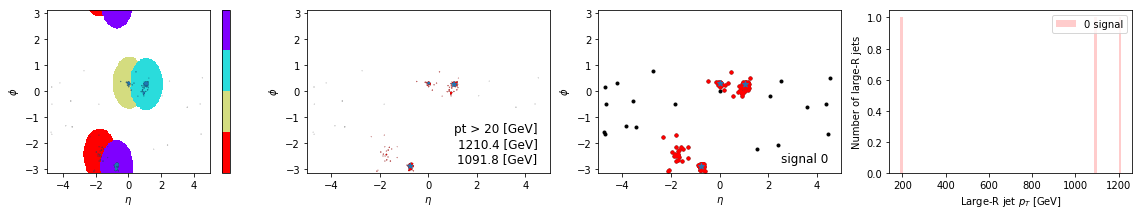

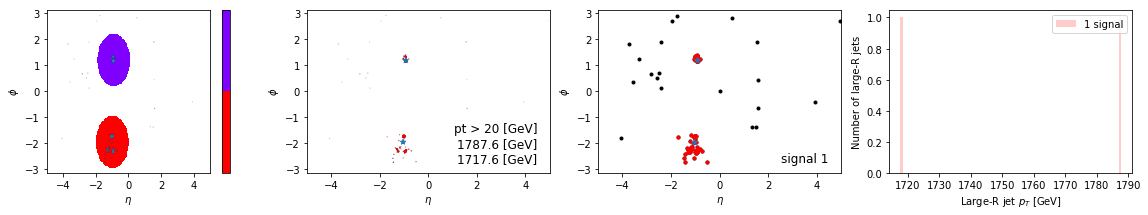

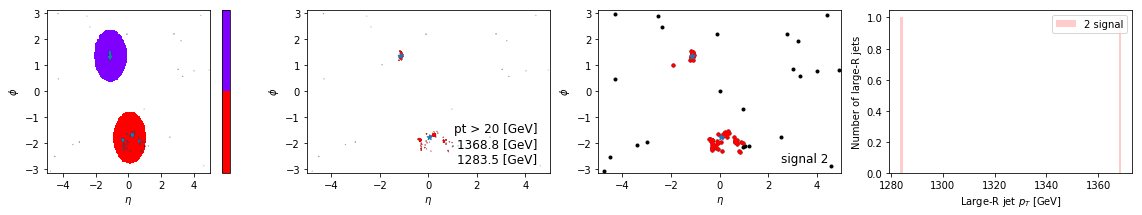

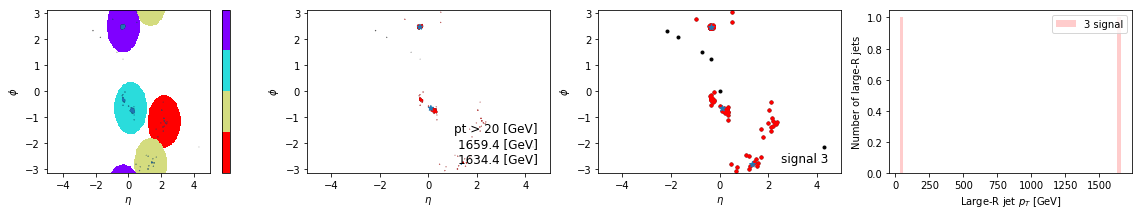

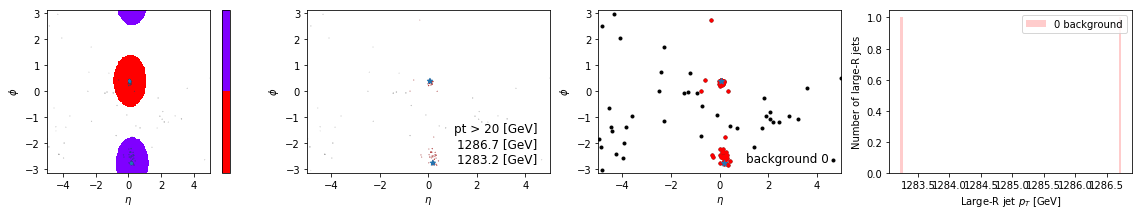

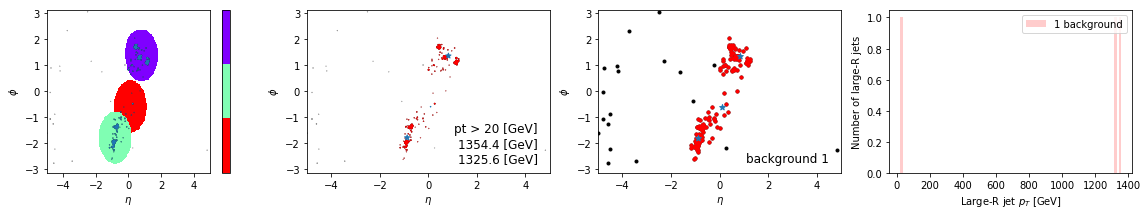

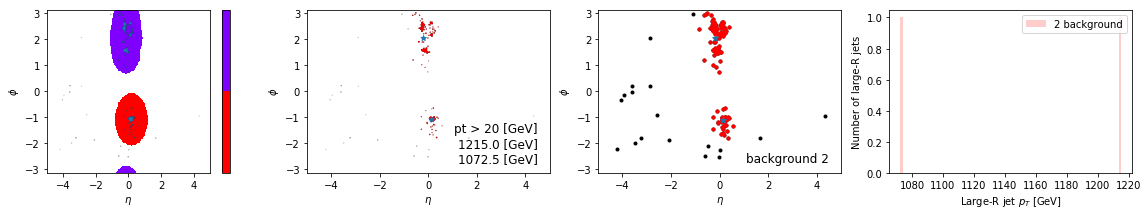

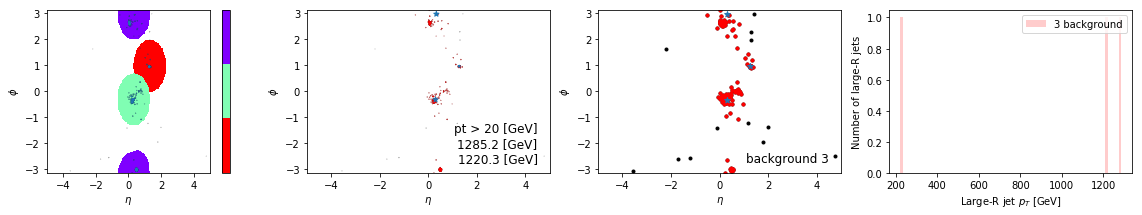

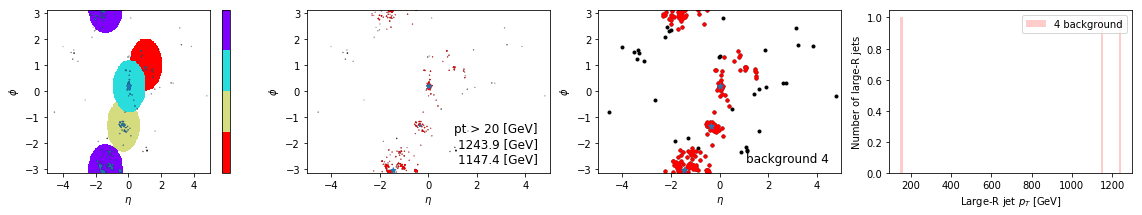

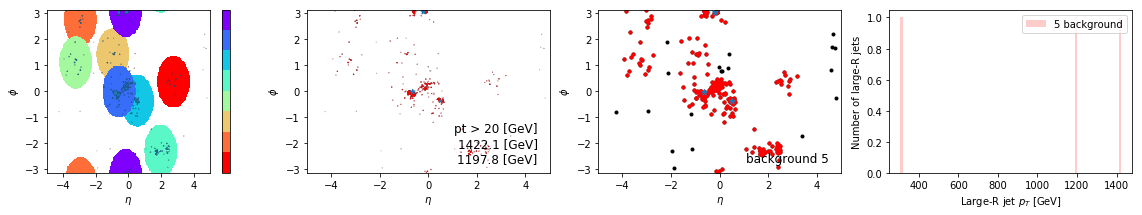

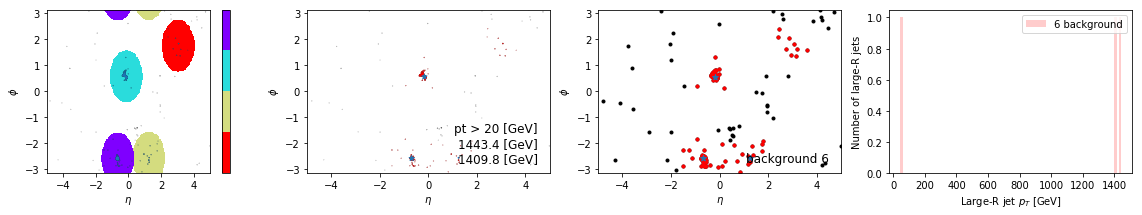

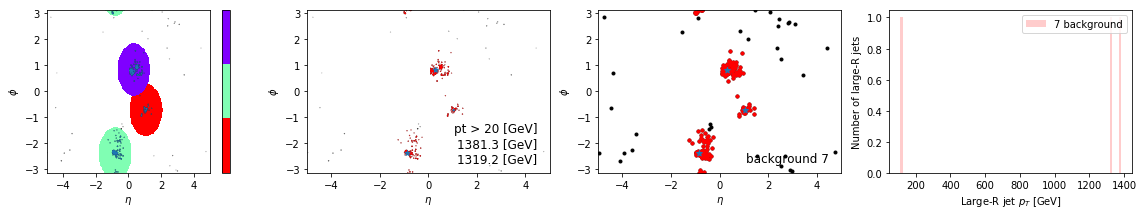

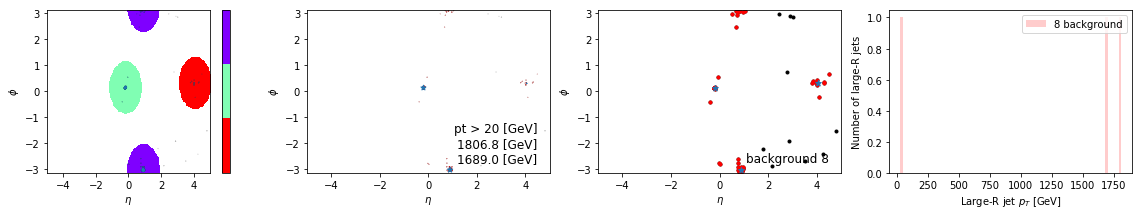

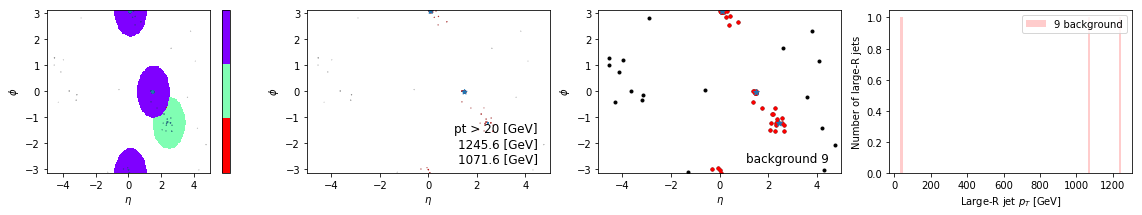

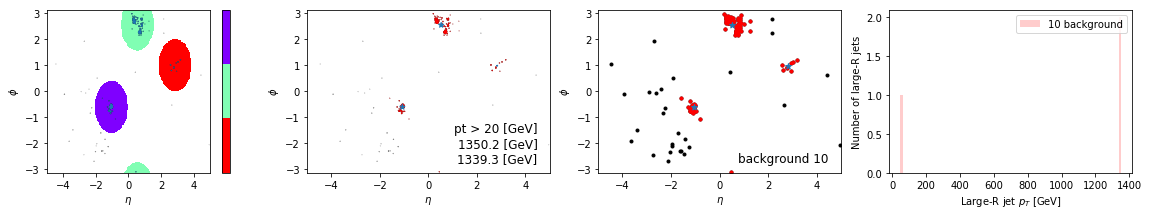

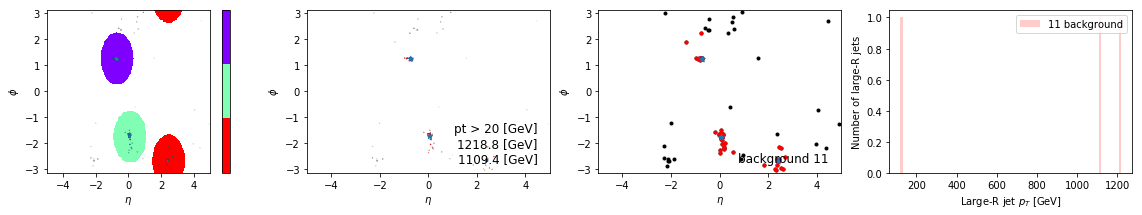

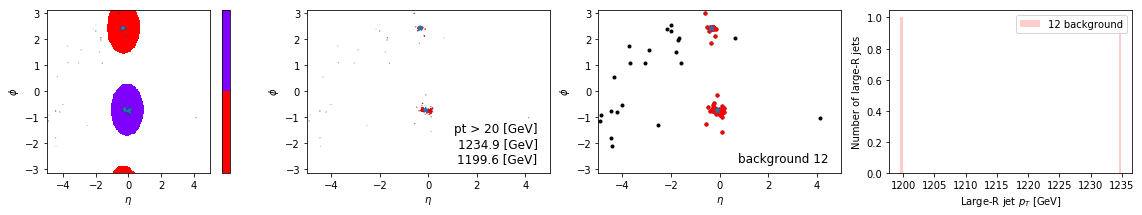

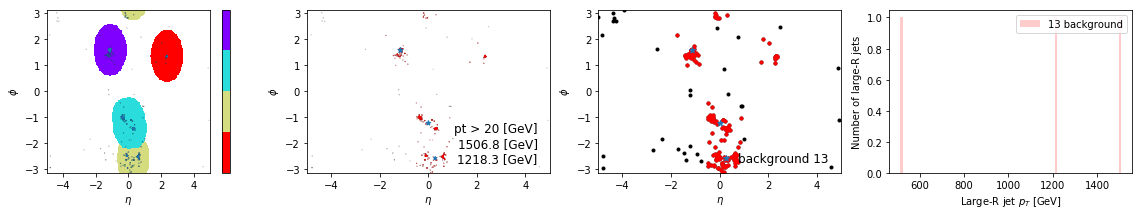

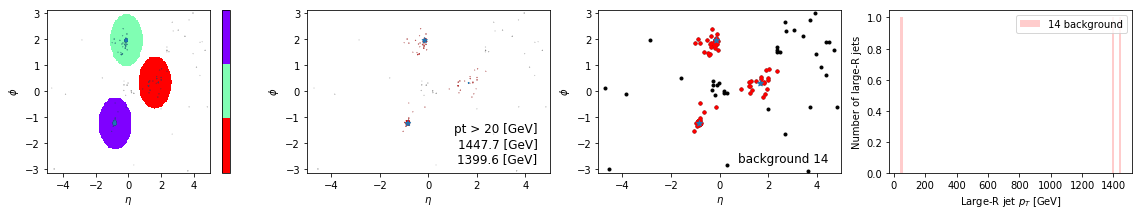

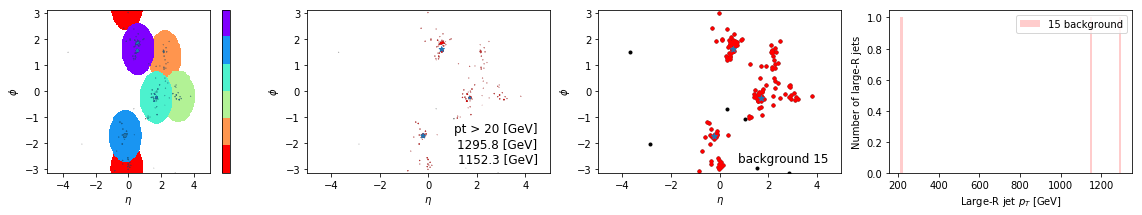

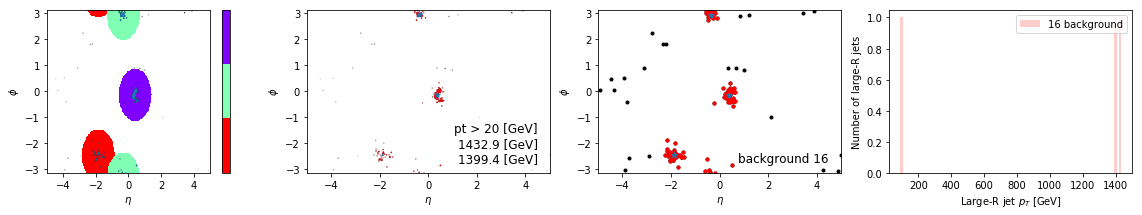

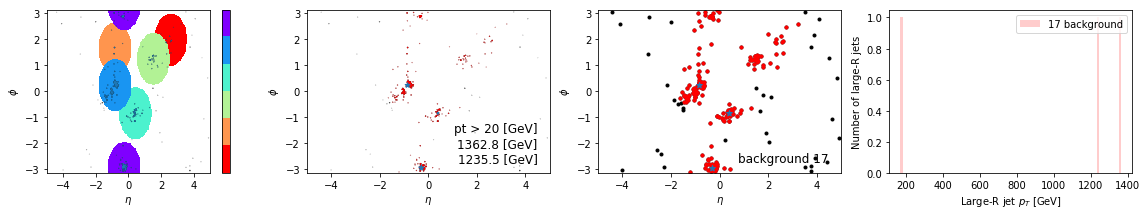

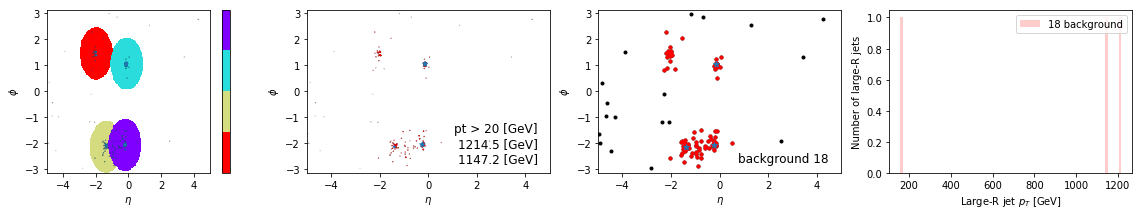

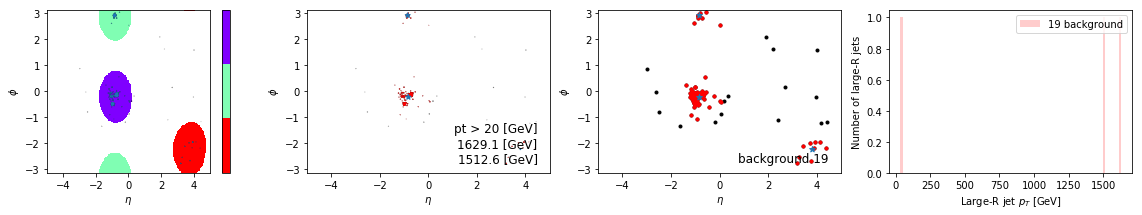

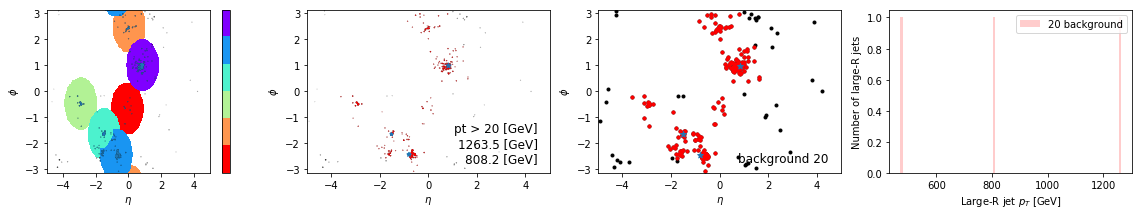

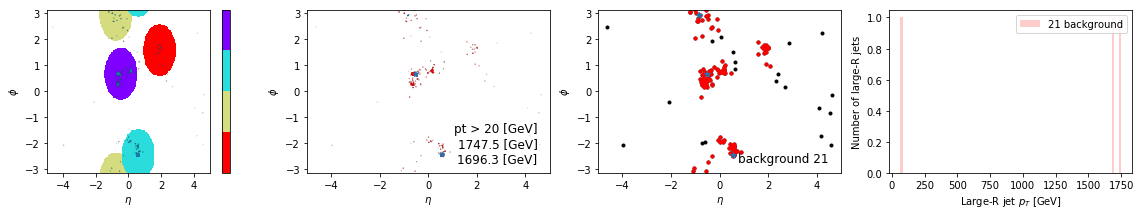

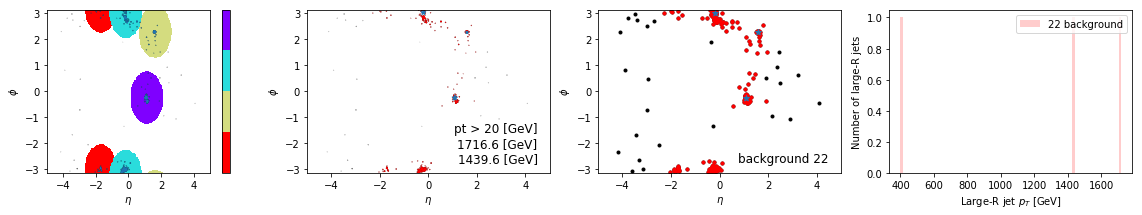

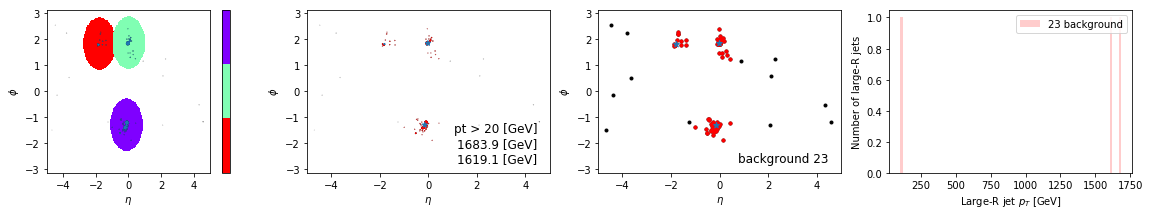

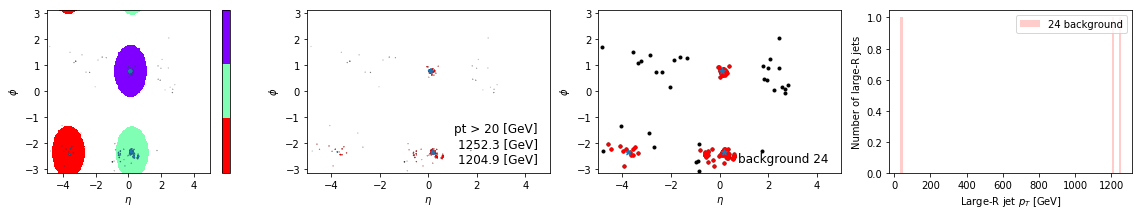

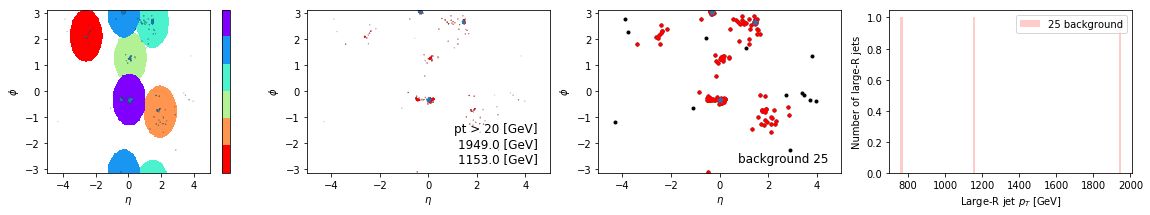

In [15]:
for mytype in ['signal', 'background']:
    hadrons = readHadrons(mytype = mytype)
    hadron_ghosts = readHadrons(mytype = mytype, filename = 'hadron_ghost.h5')
    processes = readJets(mytype = mytype)

    try:
        jets_allevent         = next(processes)
    except StopIteration:
        print('\x1b[31m[Warn.]\x1b[0m', mytype, '\x1b[31mNO\x1b[0m', 'events')
        continue

    for ievt, jets_perevent in jets_allevent.iterrows():
        try:
            hadron_perevent       = next(hadrons)
            hadron_ghost_perevent = next(hadron_ghosts)
        except StopIteration:
            continue
#         if ievt != 4: continue
        hadron_perevent = hadron_perevent.T
        hadron_ghost_perevent = hadron_ghost_perevent.T
        jets_perevent = jets_perevent.iloc[jets_perevent.nonzero()[0]]
        plot_jet_area(jets_perevent, hadron_perevent, hadron_ghost_perevent)
    

# Calculate invarient mass of jets from h5

In [16]:
from pyjet.utils import ptepm2ep

def lorentzConversion(pt_eta_phi_m):
    jet1 = pt_eta_phi_m.to_records(index=False)
    jet1 = np.array(ptepm2ep(jet1), dtype = DTYPE_EP)
    return pd.DataFrame.from_records(jet1)

    
def plotMass(m12, m13, m23):
    fig = plt.figure(figsize=(20, 3))
    ax = fig.add_subplot(1, 3, 1)
    n,b,p = plt.hist(m12['background'], bins=50, facecolor='r', alpha=0.2,label='background')
    plt.hist(m12['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
    plt.xlabel(r'$m_{12}$ [GeV]')
    plt.ylabel('Number of events')
    plt.legend(loc='upper right')
    plt.savefig("m12.pdf")
    
    ax = fig.add_subplot(1, 3, 2)
    n,b,p = plt.hist(m13['background'], bins=50, facecolor='r', alpha=0.2,label='background')
    plt.hist(m13['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
    plt.xlabel(r'$m_{13}$ [GeV]')
    plt.ylabel('Number of events')
    plt.legend(loc='upper right')
    plt.savefig("m13.pdf")

    ax = fig.add_subplot(1, 3, 3)
    n,b,p = plt.hist(m23['background'], bins=50, facecolor='r', alpha=0.2,label='background')
    plt.hist(m23['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
    plt.xlabel(r'$m_{23}$ [GeV]')
    plt.ylabel('Number of events')
    plt.legend(loc='upper right')
    plt.savefig("m23.pdf")



## Plot invarient mass of jets from h5

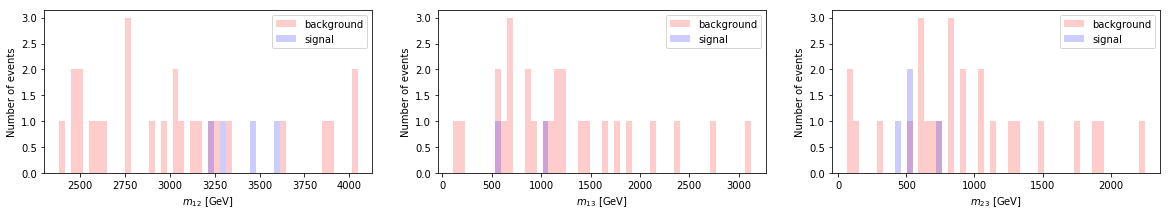

In [17]:
m12 = {}
m13 = {}
m23 = {}
for mytype in ['background', 'signal']:
    processes = readJets(mytype = mytype)
    m12[mytype] = []
    m13[mytype] = []
    m23[mytype] = []

    try:
        jets_allevent         = next(processes)
    except StopIteration:
        continue

    if 'pt_jet1' in jets_allevent.columns: jet1 = lorentzConversion(jets_allevent[['pt_jet1','eta_jet1','phi_jet1','mass_jet1']])
    if 'pt_jet2' in jets_allevent.columns: jet2 = lorentzConversion(jets_allevent[['pt_jet2','eta_jet2','phi_jet2','mass_jet2']])
    if 'pt_jet3' in jets_allevent.columns: jet3 = lorentzConversion(jets_allevent[['pt_jet3','eta_jet3','phi_jet3','mass_jet3']])
    
    m12[mytype] = ((jet1['E']+jet2['E'])**2 - (jet1['px']+jet2['px'])**2 - (jet1['py']+jet2['py'])**2 - (jet1['pz']+jet2['pz'])**2)**0.5
    m13[mytype] = ((jet1['E']+jet3['E'])**2 - (jet1['px']+jet3['px'])**2 - (jet1['py']+jet3['py'])**2 - (jet1['pz']+jet3['pz'])**2)**0.5
    m23[mytype] = ((jet2['E']+jet3['E'])**2 - (jet2['px']+jet3['px'])**2 - (jet2['py']+jet3['py'])**2 - (jet2['pz']+jet3['pz'])**2)**0.5

plotMass(m12, m13, m23)

# Replot jet area from memory

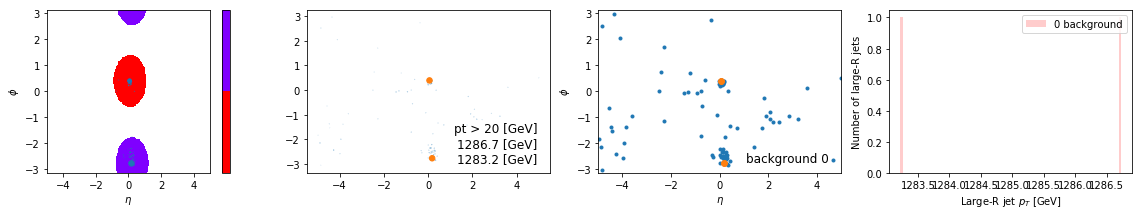

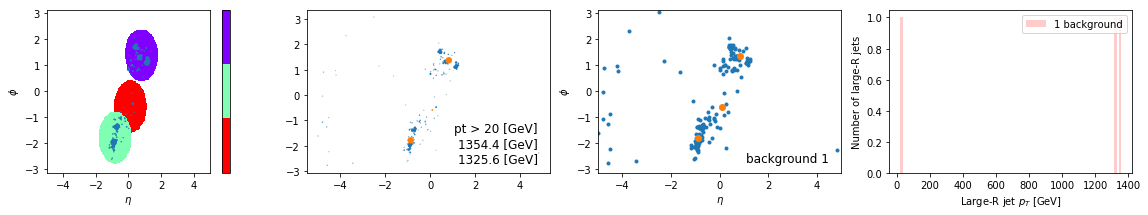

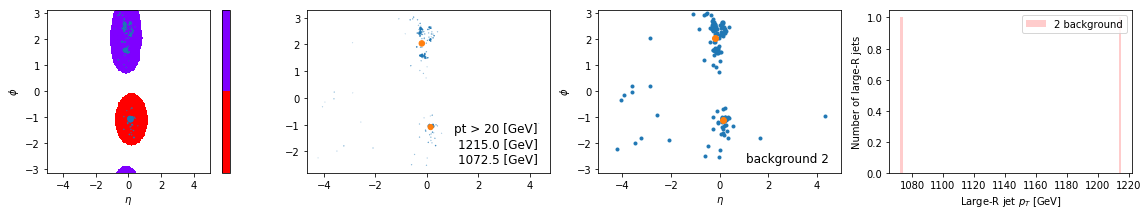

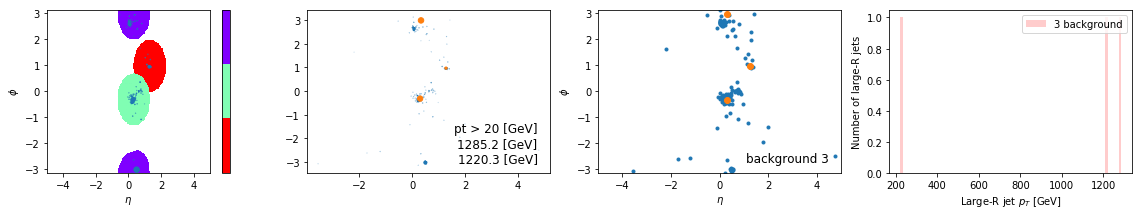

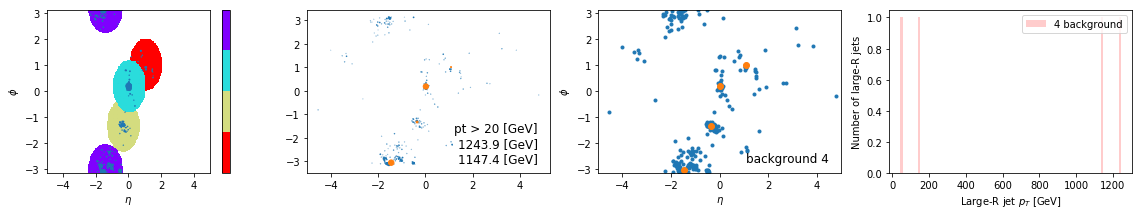

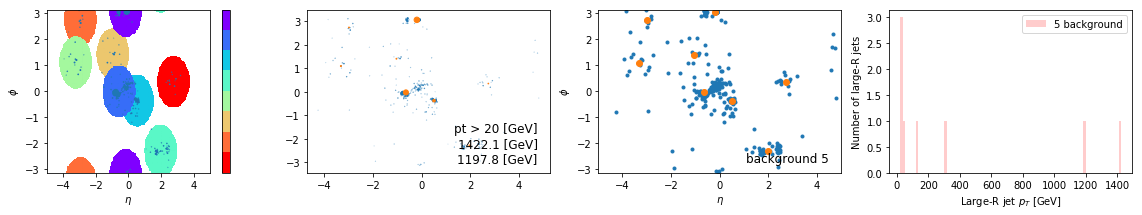

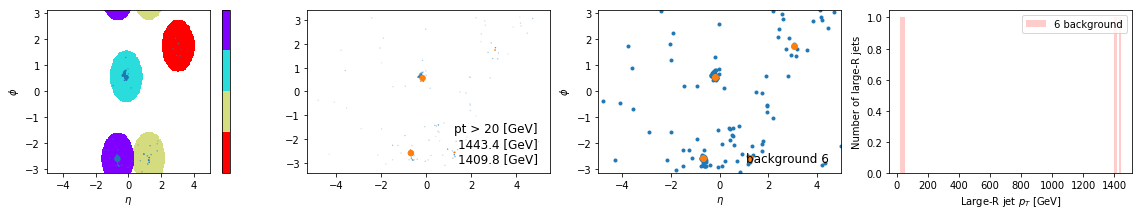

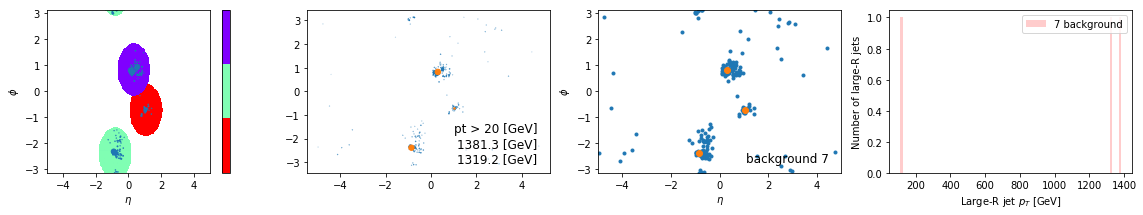

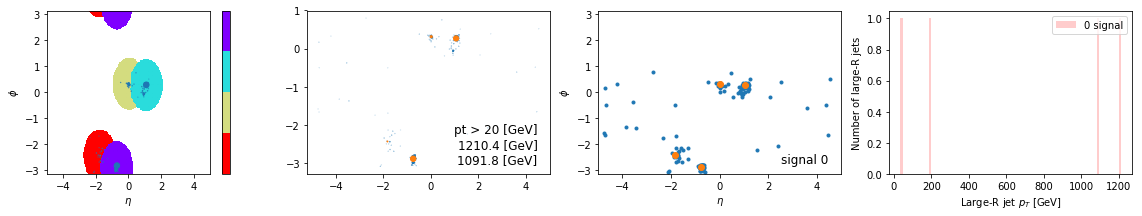

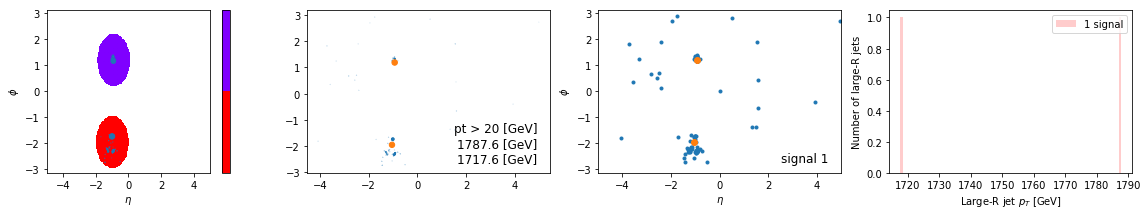

In [15]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

plotGhost = True
plotPosition = True

def replot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = 'background', ievt = 0):
    fig = plt.figure(figsize=(20, 3))

    if plotGhost:
        # define eta and phi ranges and number of bins along each axis
        eta_min, eta_max = -5., 5.
        extent = eta_min, eta_max, -np.pi, np.pi
        bins = 200
        event = all_largeRjets_ghost[mytype][ievt]
        # pick a different color for each jet
        colors = cm.rainbow(np.linspace(0, 1, len(event)))
        cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
        ax = fig.add_subplot(1, 4, 1)
        eta_edges = np.linspace(eta_min, eta_max, bins + 1)
        phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
        area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1), dtype=np.float64)
        for ijet, jet in enumerate(event):
            constit = jet.constituents_array()
            jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'], bins=(eta_edges, phi_edges))
            area += (jetarea > 0) * (ijet + 1)

        # plot all areas
        plt.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                  extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                  interpolation='none', origin='lower')
        cbar = plt.colorbar()
        cbar.ax.invert_yaxis()
        
        # overlay original event
        particles = all_hadrons_ghost[mytype][ievt]
        ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())

        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        plt.xlabel(r'$\eta$')
        plt.ylabel(r'$\phi$')

    if plotPosition:
        jets_eta = [all_largeRjets[mytype][ievt][ijet].eta for ijet in range(len(all_largeRjets[mytype][ievt]))]
        jets_phi = [all_largeRjets[mytype][ievt][ijet].phi for ijet in range(len(all_largeRjets[mytype][ievt]))]
        jets_pt = np.array([all_largeRjets[mytype][ievt][ijet].pt for ijet in range(len(all_largeRjets[mytype][ievt]))])
        ax = fig.add_subplot(1, 4, 2)
        plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], s=30 * all_hadrons[mytype][ievt]['pT'] / all_hadrons[mytype][ievt]['pT'].max(), marker='.')
        plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt/max(jets_pt), marker='o')
        ax.text(0.95, 0.05, 'pt > 20 [GeV]'+'\n{:.1f} [GeV]\n{:.1f} [GeV]'.format(jets_pt[0],jets_pt[1]),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
        ax = fig.add_subplot(1, 4, 3)
        plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], marker='.')
        plt.scatter(x=jets_eta, y=jets_phi, marker='o')
        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        plt.xlabel(r'$\eta$')
        plt.ylabel(r'$\phi$')
        ax.text(0.95, 0.05, mytype+' '+str(ievt),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=12)
        
        ax = fig.add_subplot(1, 4, 4)
        plt.hist(jets_pt, bins=100, facecolor='r', alpha=0.2, label=str(ievt)+' '+mytype)
        plt.xlabel(r'Large-R jet $p_{T}$ [GeV]')
        plt.ylabel('Number of large-R jets')
        plt.legend(loc='upper right')
    
for mytype in ['background','signal']:
    for ievt in range(len(all_largeRjets_ghost[mytype])):
        replot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = mytype, ievt = ievt)


# Replot from memory

In [16]:
def getJet(alljets, index):
    jet = {}
    for mytype in ['background','signal']:
        jet[mytype]={'pt':[], 'eta':[], 'phi':[]}
        for ievt in range(len(all_largeRjets[mytype])):
            jet[mytype]['pt'] += [alljets[mytype][ievt][index].pt]
            jet[mytype]['eta'] += [alljets[mytype][ievt][index].eta]
            jet[mytype]['phi'] += [alljets[mytype][ievt][index].phi]
    return jet

lead_largeRjets, sublead_largeRjets = getJet(all_largeRjets, 0), getJet(all_largeRjets, 1)
lead_smallRjets, sublead_smallRjets = getJet(all_smallRjets, 0), getJet(all_smallRjets, 1)


## Replot jet $p_\text{T}$

NameError: name 'lead_largeRjets' is not defined

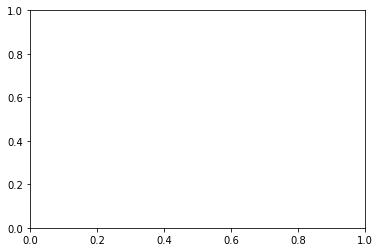

In [18]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(lead_largeRjets['background']['pt'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(lead_largeRjets['signal']['pt'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("leadjetpt.pdf")

## Replot dijet mass

In [18]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(all_largeRjets[mytype])):
        E = all_largeRjets[mytype][k][0].e+all_largeRjets[mytype][k][1].e
        px = all_largeRjets[mytype][k][0].px+all_largeRjets[mytype][k][1].px
        py = all_largeRjets[mytype][k][0].py+all_largeRjets[mytype][k][1].py
        pz = all_largeRjets[mytype][k][0].pz+all_largeRjets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]


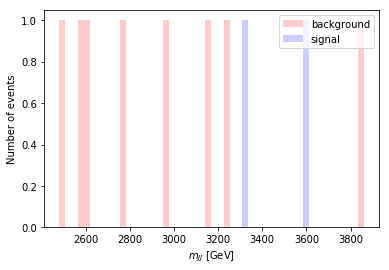

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("mjj.pdf")